# Support Vector Machine

In this course we go through the Support Vector Machine method. It is divided into few parts:
1. Linear C-SVM classifier
2. RBF and polynomial kernels
3. nuSVM classifier
4. Multiclass SVM
5. Use case: skin cancer diagnosis
6. Exercises

## Data set

We use in this section the classic IRIS data set. It can be loaded using the scikit-learn package.

In [14]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.model_selection import train_test_split

iris = load_iris()
data_set = iris.data
labels = iris.target

data_set = data_set[labels!=2]
labels = labels[labels!=2]

train_data_set, test_data_set, train_labels, test_labels = train_test_split(
    data_set, labels, test_size=0.2, random_state=15)

#train_data_set = iris.data[0:len(iris.target)-20,:]
#train_labels = iris.target[0:len(iris.target)-20]
#unique_labels = np.unique(iris.target)

#test_data_set = iris.data[-20:,:]
#test_labels = iris.target[-20:]

%store train_data_set
%store train_labels
%store test_data_set
%store test_labels

Stored 'train_data_set' (ndarray)
Stored 'train_labels' (ndarray)
Stored 'test_data_set' (ndarray)
Stored 'test_labels' (ndarray)


## Idea

The idea of SVM is to find a hyperplane in a higher dimension. There are many hyperplanes possible, but only one gives best results. A few possible separation options are shown below.

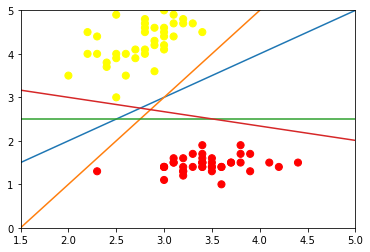

In [22]:
import matplotlib.pyplot as plt
from matplotlib import transforms

plt.scatter(train_data_set[:, 1], train_data_set[:, 2], c=train_labels, s=50, cmap='autumn')

hyperplanes_number = 10
x = np.arange(10)

plt.plot(x, x)
plt.plot(x, 2*x-3)
plt.plot(x, 2.5+x*0)
plt.plot(x, -0.33*x+3.66)

plt.xlim(1.5, 5)
plt.ylim(0, 5)

plt.show()

## Maximum margin

The best hyperplane is the one with the widest margin. The margin is set as $\frac{1}{||w||}$ and our goal is to minimize $w$.

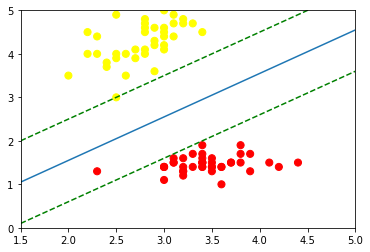

In [23]:
import matplotlib.pyplot as plt
from matplotlib import transforms

plt.scatter(train_data_set[:, 1], train_data_set[:, 2], c=train_labels, s=50, cmap='autumn')

hyperplanes_number = 10
x = np.arange(10)

plt.plot(x, x-0.45)
plt.plot(x, x-1.4,'g--')
plt.plot(x, x+0.5,'g--')
#plt.plot(x, 2*x-3)
#plt.plot(x, 2.5+x*0)
#plt.plot(x, -0.33*x+3.66)

plt.xlim(1.5, 5)
plt.ylim(0, 5)

plt.show()

## Convex problem

So far we know that have to maximize:
\begin{equation}
    \frac{1}{||w||},
\end{equation}
what means that we need to:
\begin{equation}
    \min \frac{1}{2}w^{T}w
\end{equation}
and take into consideration some constraints:
\begin{equation}
    y_{i}(w^{T}x_{i}+w_{0})\geq1 \text{ } \forall i=1,\ldots,n.
\end{equation}
This problem is a convex problem.

We have to solve a quadratic optimization problem with constraints to find an optimal separating hyperplane. Let's assume we have to minimize the function $f(x)$ with the constraint $g(x) = 0$, where $x$ might be a vector of variables $x = (x_{1}, \ldots, x_{n})$. We can notice that the minimum of the $f(x)$ is found when the gradients of these two functions are parallel i.e.
\begin{equation}
 \nabla f(x)=\lambda\nabla g(x),
\end{equation}
where $\alpha$ is the scaling factor, we call it a Lagrange multiplier. To find the minimum of $f$ under the constraint $g$, we just need to solve:
\begin{equation}
 \label{ex:heartlagrangian1}
 \nabla f(x) - \lambda\nabla g(x) = 0.
\end{equation}
To solve that equation we can define a function 
\begin{align}
L(x, \lambda) = f(x) - \lambda g(x),   
\end{align}
then its gradient is 
\begin{align}
\nabla L(x, \lambda) = \nabla f(x) - \lambda \nabla g(x).
\end{align}
Solving 
\begin{align}
\nabla L(x, \lambda) = 0    
\end{align} 
allows us to find the minimum. In our example we have 80 objects. It means we have 80 equations and 80 lambdas to find. 

The data set we used for training need to be fixed as we have a binary classifier:

In [24]:
# fix
train_labels[train_labels<1] = -1
test_labels[test_labels<1] = -1

objects_count = len(train_labels)

We use a linear kernel that can be written as:
\begin{equation}
K=xx^{T}
\end{equation}

In [25]:
linear_kernel = np.dot(train_data_set, train_data_set.T)

To solve the quadrative optimization problem we use the cvopt libary. Based on the documentation it solves the problem by minimizing
\begin{equation}
\frac{1}{2}x'*P*x + q'*x,
\end{equation} 
subject to 
\begin{equation}
G * x <= h
\end{equation}
and
\begin{equation}
A * x = b,
\end{equation}
where $P=K*y_{i}*y_{j}$, $q$ is a vector of -1. In the equations above $x$ are our $\lambda$s.

In [26]:
# Assemble the matrices for the constraints
P = train_labels * train_labels.transpose() * linear_kernel
q = -np.ones((objects_count, 1))

G = -np.eye(objects_count)
h = np.zeros((objects_count, 1))
A = train_labels.reshape(1, objects_count)
A = A.astype(float)
b = 0.0

The solver of the equations can be invoked as below. The $x$ value are our $\lambda$s.

In [27]:
import cvxopt

sol = cvxopt.solvers.qp(cvxopt.matrix(P), cvxopt.matrix(q), cvxopt.matrix(G), cvxopt.matrix(h), cvxopt.matrix(A), cvxopt.matrix(b))
lambdas = np.array(sol['x'])

print(lambdas)

     pcost       dcost       gap    pres   dres
 0: -4.5474e-01 -5.7385e-01  1e+02  1e+01  1e+00
 1: -2.8868e-02 -6.4500e-02  4e+00  4e-01  4e-02
 2:  2.2639e-03 -4.8540e-02  7e-02  2e-03  2e-04
 3: -9.9525e-03 -1.9427e-02  9e-03  2e-18  4e-16
 4: -1.1819e-02 -1.5127e-02  3e-03  1e-18  2e-16
 5: -1.2520e-02 -1.5470e-02  3e-03  3e-18  2e-16
 6: -1.4816e-02 -1.5217e-02  4e-04  2e-18  3e-16
 7: -1.4959e-02 -1.5018e-02  6e-05  4e-18  3e-16
 8: -1.4947e-02 -1.5008e-02  6e-05  4e-18  2e-16
 9: -1.4985e-02 -1.4989e-02  5e-06  2e-18  3e-16
10: -1.4987e-02 -1.4987e-02  3e-07  4e-18  3e-16
11: -1.4987e-02 -1.4987e-02  3e-09  4e-18  3e-16
Optimal solution found.
[[2.90242318e-11]
 [7.66118368e-11]
 [2.58605844e-11]
 [2.52586184e-11]
 [6.59520523e-11]
 [5.22546000e-11]
 [2.72126969e-11]
 [5.17161817e-11]
 [2.70417576e-03]
 [2.54478557e-11]
 [1.83990857e-11]
 [3.90546778e-11]
 [1.97733389e-11]
 [1.55173429e-11]
 [3.34516650e-11]
 [2.06911093e-11]
 [3.97898927e-11]
 [3.76987117e-11]
 [2.50969274e-11